This solution is inspired by Shlomoron’s approach, which achieved 10th place in the
Stanford Ribonanza RNA Folding competition. The method presented here borrows key 
elements from his solution, including the use of 1D Convolutional Neural Networks 
combined with a Transformer model, a custom weighted loss function to incorporate 
uncertainty into the predictions, and an ensembling strategy to combine predictions 
rom multiple models for improved robustness.

Shlomoron’s method is based on a sequence-only model and introduces several novel 
aspects, such as:
  - The use of a convolutional architecture to automatically capture positional 
    relationships within the RNA sequences.
  - A weighted loss function that adjusts the loss based on the uncertainty (error) 
    in the reactivity measurements.
  - The concept of using "potentials" in the loss function, inspired by the 
    shell theorem, to account for the probability distribution of reactivity values.
  - The application of ensembling to combine multiple models and enhance overall 
    performance.

While my implementation deviates in certain areas, the core inspiration comes 
from Shlomoron’s use of Transformer blocks and ensembling strategies. I chose to 
focus on the Transformer encoder blocks and incorporated K-Fold cross-validation 
for better generalization and validation during training.

Credits:
- Shlomoron: 10th place solution for the Stanford Ribonanza RNA Folding Competition
  GitHub: https://github.com/shlomoron/Stanford-Ribonanza-RNA-Folding-10th-place-solution
- This solution is inspired by his approach, particularly in terms of the use of Transformer 
  blocks for sequence modeling and handling uncertainties in the data.

# **Imports**

In [1]:
import tensorflow as tf
# import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shutil
import math
import pandas as pd
import gc
import os
import time

D0520 01:31:13.987744137      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0520 01:31:13.987773822      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0520 01:31:13.987777632      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0520 01:31:13.987780802      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0520 01:31:13.987783545      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0520 01:31:13.987786582      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0520 01:31:13.987789454      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0520 01:31:13.

In [2]:
# Configure Strategy. Assume TPU...if not set default for GPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
    print("REPLICAS: ", strategy.num_replicas_in_sync)
except:
    strategy = tf.distribute.get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# **Data API pipeline**

In [3]:
tffiles_path = '/kaggle/input/srrf-tfrecords-ds/tfds'
tffiles = [f'{tffiles_path}/{x}.tfrecord' for x in range(164)]

# **Configs**

In [4]:
# Configuration parameters

DEBUG = False

PAD_x = 0.0 # Padding value for features
PAD_y = np.nan # Padding value for targets
X_max_len = 206 # Maximum length of sequences
batch_size = 128  # Batch size
val_batch_size = 5512 # Batch size for validation set

num_vocab = 5 #(ACGUN)
hidden_dim = 192 # Dimension of hidden layer in the model

# **Decoding TFRecords**

In [5]:
# Function to decode TFRecord files
def decode_tfrec(record_bytes):
    # Define the schema for the TFRecord file. Each feature in the TFRecord file is defined with its name and data type.
    schema = {
        "id": tf.io.VarLenFeature(dtype=tf.string),  # ID of the record
        "seq": tf.io.VarLenFeature(dtype=tf.float32),  # Sequence data
        "dataset_name_2A3": tf.io.VarLenFeature(dtype=tf.string),  # Dataset name for 2A3
        "dataset_name_DMS": tf.io.VarLenFeature(dtype=tf.string),  # Dataset name for DMS
        "reads_2A3": tf.io.VarLenFeature(dtype=tf.float32),  # Reads for 2A3
        "reads_DMS": tf.io.VarLenFeature(dtype=tf.float32),  # Reads for DMS
        "signal_to_noise_2A3": tf.io.VarLenFeature(dtype=tf.float32),  # Signal to noise ratio for 2A3
        "signal_to_noise_DMS": tf.io.VarLenFeature(dtype=tf.float32),  # Signal to noise ratio for DMS
        "SN_filter_2A3": tf.io.VarLenFeature(dtype=tf.float32),  # Signal to noise filter for 2A3
        "SN_filter_DMS": tf.io.VarLenFeature(dtype=tf.float32),  # Signal to noise filter for DMS
        "reactivity_2A3": tf.io.VarLenFeature(dtype=tf.float32),  # Reactivity for 2A3
        "reactivity_DMS": tf.io.VarLenFeature(dtype=tf.float32),  # Reactivity for DMS
        "reactivity_error_2A3": tf.io.VarLenFeature(dtype=tf.float32),  # Reactivity error for 2A3
        "reactivity_error_DMS": tf.io.VarLenFeature(dtype=tf.float32)  # Reactivity error for DMS
    }

    # Parse the record using the defined schema. This will return a dictionary where each key-value pair corresponds to a feature in the TFRecord file.
    features = tf.io.parse_single_example(record_bytes, schema)

    # Convert the sparse tensors in the features dictionary to dense tensors. This is necessary because some TensorFlow operations do not support sparse tensors.
    # Only the keys that are needed in the output are converted and stored in the 'out' dictionary.
    out = {key: tf.sparse.to_dense(value) for key, value in features.items() if key in ['seq', 'SN_filter_2A3', 'SN_filter_DMS', 'reads_2A3', 'reads_DMS', 'signal_to_noise_2A3', 'signal_to_noise_DMS', 'reactivity_2A3', 'reactivity_DMS']}

    # Return the 'out' dictionary which contains the dense tensors.
    return out

# This function is used to decode TFRecord files, which are a common format for storing large amounts of data in TensorFlow. The
# decode_tfrec function takes in the raw bytes of a TFRecord file, parses it according to a predefined schema, and returns a dictionary of
# dense tensors. The keys in the output dictionary are a subset of the keys in the input features dictionary. The function converts only these
# selected features from sparse to dense tensors. This is because some TensorFlow operations do not support sparse tensors. The function
# returns the dictionary of dense tensors. This dictionary can then be used for further processing, such as feeding the data into a machine learning model.

# **Filter**

In [6]:
# Define the first filter function
def filter_function_1(x):
    # Extract the 'SN_filter_2A3' and 'SN_filter_DMS' values from the input dictionary 'x'
    SN_filter_2A3 = x['SN_filter_2A3']
    SN_filter_DMS = x['SN_filter_DMS']
    # Return True if both 'SN_filter_2A3' and 'SN_filter_DMS' are 1, otherwise return False
    return tf.cond((SN_filter_2A3 == 1) and (SN_filter_DMS == 1), true_fn=lambda: True, false_fn=lambda: False)

# Define the second filter function
def filter_function_2(x):
    # Extract the 'reads_2A3', 'reads_DMS', 'signal_to_noise_2A3', and 'signal_to_noise_DMS' values from the input dictionary 'x'
    reads_2A3, reads_DMS, signal_to_noise_2A3, signal_to_noise_DMS = x['reads_2A3'], x['reads_DMS'], x['signal_to_noise_2A3'], x['signal_to_noise_DMS']
    # Define a condition that checks if 'reads_2A3' is greater than 100 and 'signal_to_noise_2A3' is greater than 1, or if 'reads_DMS' is greater than 100 and 'signal_to_noise_DMS' is greater than 1
    cond = (reads_2A3 > 100 and signal_to_noise_2A3 > 1) or (reads_DMS > 100 and signal_to_noise_DMS > 1)
    # Return True if the condition is met, otherwise return False
    return tf.cond(cond, true_fn=lambda: True, false_fn=lambda: False)

# **Preprocessing**

In [7]:
# Function to filter and replace values below a certain threshold with NaN
def nan_below_filter(x):
    # Extract the necessary values from the input dictionary 'x'
    reads_2A3 = x['reads_2A3']  # Reads for 2A3
    reads_DMS = x['reads_DMS']  # Reads for DMS
    signal_to_noise_2A3 = x['signal_to_noise_2A3']  # Signal to noise ratio for 2A3
    signal_to_noise_DMS = x['signal_to_noise_DMS']  # Signal to noise ratio for DMS
    reactivity_2A3 = x['reactivity_2A3']  # Reactivity for 2A3
    reactivity_DMS = x['reactivity_DMS']  # Reactivity for DMS

    # If the reads for 2A3 is less than 100 or the signal to noise ratio for 2A3 is less than 1, replace the reactivity for 2A3 with NaN
    if reads_2A3<100 or signal_to_noise_2A3<1:
        reactivity_2A3 = np.nan+reactivity_2A3

    # If the reads for DMS is less than 100 or the signal to noise ratio for DMS is less than 1, replace the reactivity for DMS with NaN
    if reads_DMS<100 or signal_to_noise_DMS<1:
        reactivity_DMS = np.nan+reactivity_DMS

    # Update the reactivity values in the input dictionary 'x'
    x['reactivity_2A3'] = reactivity_2A3
    x['reactivity_DMS'] = reactivity_DMS

    # Return the updated dictionary
    return x

def concat_target(x):
    # Concatenate 'reactivity_2A3' and 'reactivity_DMS' along a new axis and clip values between 0 and 1
    target = tf.clip_by_value(tf.concat([x['reactivity_2A3'][..., tf.newaxis], x['reactivity_DMS'][..., tf.newaxis]], axis = 1), 0, 1)

    # Return 'seq' and the processed target
    return x['seq'], target

In [8]:
# Function to get a TFRecord dataset
def get_tfrec_dataset(tffiles, shuffle, batch_size, cache = False, to_filter = False,
                      calculate_sample_num = True, to_repeat = False):
    # Create a TFRecordDataset with automatic interleaving from multiple files, prefetching, and GZIP compression
    ds = tf.data.TFRecordDataset(
        tffiles, num_parallel_reads=tf.data.AUTOTUNE, compression_type = 'GZIP').prefetch(tf.data.AUTOTUNE)

    # Map the decode function to the dataset
    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)

    # Apply the appropriate filter function if specified
    if to_filter == 'filter_1':
        ds = ds.filter(filter_function_1)
    elif to_filter == 'filter_2':
        ds = ds.filter(filter_function_2)

    # Map the nan_below_filter function to the dataset
    ds = ds.map(nan_below_filter, tf.data.AUTOTUNE)

    # Map the concat_target function to the dataset
    ds = ds.map(concat_target, tf.data.AUTOTUNE)

    # Cache the dataset if specified
    if cache:
        ds = ds.cache()

    # Initialize the sample count
    samples_num = 0

    # Calculate the number of samples in the dataset if specified
    if calculate_sample_num:
        samples_num = ds.reduce(0, lambda x,_: x+1).numpy()        

    # Shuffle the dataset if specified
    if shuffle:
        if shuffle == -1:
            ds = ds.shuffle(samples_num, reshuffle_each_iteration = True)
        else:
            ds = ds.shuffle(shuffle, reshuffle_each_iteration = True)

    # Repeat the dataset indefinitely if specified
    if to_repeat:
        ds = ds.repeat()
         
    # Batch the dataset with padding if a batch size is specified
    if batch_size:
        ds = ds.padded_batch(
            batch_size, padding_values=(PAD_x, PAD_y), padded_shapes=([X_max_len],[X_max_len, 2]), drop_remainder=True)

    # Prefetch the dataset for performance
    ds = ds.prefetch(tf.data.AUTOTUNE)

    # Return the dataset and the number of samples
    return ds, samples_num

# This function is used to create a TensorFlow dataset from a set of TFRecord files. It applies various transformations to the dataset, such as
# decoding, filtering, padding, batching, and prefetching. The function returns the processed dataset and the number of samples in the dataset.
# This processed dataset can then be used for further processing, such as feeding the data into a machine learning model.

# **Model layers**

In [9]:
# Transformer Encoder Layer
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        # Multi-head attention layer
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        # Feed forward network
        self.ffn = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(feed_forward_dim, activation="relu"),  # First layer of the FFN with ReLU activation
                tf.keras.layers.Dense(embed_dim),  # Second layer of the FFN
            ]
        )
        # Layer normalization layers
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Dropout layers
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        # Support for masking
        self.supports_masking = True

    def call(self, inputs, training, mask):
        # Expand and repeat the mask for multi-head attention
        att_mask = tf.expand_dims(mask, axis=-1)
        att_mask = tf.repeat(att_mask, repeats=tf.shape(att_mask)[1], axis=-1)
        # Apply multi-head attention and dropout
        attn_output = self.att(inputs, inputs, attention_mask = att_mask)
        attn_output = self.dropout1(attn_output, training=training)
        # Add and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Apply feed forward network and dropout
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add and normalize
        return self.layernorm2(out1 + ffn_output)

# Positional Encoding Layer
class positional_encoding_layer(tf.keras.layers.Layer):
    def __init__(self, num_vocab=5, maxlen=500, hidden_dim=384):
        super().__init__()
        # Hidden dimension size
        self.hidden_dim = hidden_dim
        # Compute the positional encoding
        self.pos_emb = self.positional_encoding(maxlen-1, hidden_dim)
        # Support for masking
        self.supports_masking = True

    def call(self, x):
        # Get the maximum length
        maxlen = tf.shape(x)[-2]
        # Scale the input by the square root of the hidden dimension size
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32)))
        # Add the positional encoding
        return x + self.pos_emb[:maxlen, :]

    def positional_encoding(self, maxlen, hidden_dim):
        # Compute the positional encoding
        depth = hidden_dim/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding

# **Loss function**

In [10]:
def loss_fn_metric_pe(labels, targets):
    # Create a mask where labels are not NaN
    labels_mask = tf.math.is_nan(labels)
    
    # Replace NaN values in labels with zeros
    labels = tf.where(labels_mask, tf.zeros_like(labels), labels)
    
    # Count the number of non-NaN values in labels
    mask_count = tf.math.reduce_sum(tf.cast(~labels_mask, tf.float32))
    
    # Avoid division by zero by replacing zero targets with ones
    targets = tf.where(tf.equal(targets, 0), tf.ones_like(targets), targets)
    
    # Compute the percentage error
    error = (labels - targets) / targets
    
    # Replace the error values where labels are NaN with zeros
    error = tf.where(labels_mask, tf.zeros_like(error), error)
    
    # Multiply by 100 to get the percentage error
    error = error * 100
    
    # Clip the error to a maximum of 100% and minimum of 0% to prevent excessively large or small values
    error = tf.clip_by_value(error, 0, 100)
    
    # Compute the mean error over non-NaN values
    error = tf.math.reduce_sum(error) / mask_count
    
    return error

def loss_fn_metric_mape(labels, targets):
    # Create a mask where labels are not NaN
    labels_mask = tf.math.is_nan(labels)
    
    # Replace NaN values in labels with zeros
    labels = tf.where(labels_mask, tf.zeros_like(labels), labels)
    
    # Count the number of non-NaN values in labels
    mask_count = tf.math.reduce_sum(tf.cast(~labels_mask, tf.float32))
    
    # Avoid division by zero by replacing zero targets with ones
    targets = tf.where(tf.equal(targets, 0), tf.ones_like(targets), targets)
    
    # Compute the percentage error
    loss = tf.math.abs((labels - targets) / targets)
    
    # Replace the loss values where labels are NaN with zeros
    loss = tf.where(labels_mask, tf.zeros_like(loss), loss)
    
    # Multiply by 100 to get the percentage error
    loss = loss * 100
    
    # Clip the loss to a maximum of 100% to prevent excessively large values
    loss = tf.clip_by_value(loss, 0, 100)
    
    # Compute the mean loss over non-NaN values
    loss = tf.math.reduce_sum(loss) / mask_count
    
    return loss

def loss_fn_metric_rmse(labels, targets):
    # Create a mask where True if the label is NaN and False otherwise
    labels_mask = tf.math.is_nan(labels)
    
    # Replace NaN values in labels with zeros using the mask
    labels = tf.where(labels_mask, tf.zeros_like(labels), labels)
    
    # Count the number of non-NaN values in labels
    mask_count = tf.math.reduce_sum(tf.where(labels_mask, tf.zeros_like(labels), tf.ones_like(labels)))
    
    # Compute the square of the difference between labels and targets
    squared_diff = tf.square(labels - targets)
    
    # Apply the mask to the squared_diff, effectively ignoring the loss where the label was NaN
    squared_diff = tf.where(labels_mask, tf.zeros_like(squared_diff), squared_diff)
    
    # Compute the mean of the squared differences, considering only the non-NaN values in labels
    mean_squared_diff = tf.math.reduce_sum(squared_diff)/mask_count
    
    # Compute the square root of the mean squared differences (this is the RMSE)
    rmse = tf.sqrt(mean_squared_diff)
    
    return rmse  # Return the computed RMSE

def loss_fn(labels, targets):
    # Create a mask where True if the label is NaN and False otherwise
    labels_mask = tf.math.is_nan(labels)
    
    # Replace NaN values in labels with zeros using the mask
    labels = tf.where(labels_mask, tf.zeros_like(labels), labels)
    
    # Count the number of non-NaN values in labels
    mask_count = tf.math.reduce_sum(tf.where(labels_mask, tf.zeros_like(labels), tf.ones_like(labels)))
    
    # Compute the absolute difference between labels and targets
    loss = tf.math.abs(labels - targets)
    
    # Apply the mask to the loss, effectively ignoring the loss where the label was NaN
    loss = tf.where(labels_mask, tf.zeros_like(loss), loss)
    
    # Compute the mean loss, considering only the non-NaN values in labels
    loss = tf.math.reduce_sum(loss)/mask_count
    
    return loss  # Return the computed loss

def accuracy(labels, targets):
    # Create a mask where True if the label is NaN and False otherwise
    labels_mask = tf.math.is_nan(labels)
    
    # Replace NaN values in labels with zeros using the mask
    labels = tf.where(labels_mask, tf.zeros_like(labels), labels)
    
    # Count the number of non-NaN values in labels
    mask_count = tf.math.reduce_sum(tf.where(labels_mask, tf.zeros_like(labels), tf.ones_like(labels)))
    
    # Compute the number of correct predictions
    correct_predictions = tf.math.equal(tf.round(labels), tf.round(targets))
    
    # Apply the mask to the correct_predictions, effectively ignoring the correct_predictions where the label was NaN
    correct_predictions = tf.where(labels_mask, tf.zeros_like(correct_predictions), correct_predictions)
    
    # Compute the accuracy, considering only the non-NaN values in labels
    accuracy = tf.math.reduce_sum(tf.cast(correct_predictions, tf.float32))/mask_count
    
    return accuracy  # Return the computed accuracy

# **Model**

In [11]:
# def get_ranger_gc_optimizer():
#     radam = tfa.optimizers.RectifiedAdam(
#         learning_rate=1e-3,  # flat learning rate
#         beta_1=0.9,
#         beta_2=0.999,
#         epsilon=1e-7,
#         weight_decay=0.1,  # weight decay set to 0.1
#         amsgrad=False,
#         sma_threshold=5.0,
#         total_steps=0,
#         warmup_proportion=0.1,
#         min_lr=0.0  # learning rate reduces down to 0 at the end of training
#     )
#     radam.get_gradients = centralized_gradients_for_optimizer(radam)
#     ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
#     return ranger

In [12]:
def get_model(hidden_dim = 384, max_len = 206):
    with strategy.scope():
        # Input layer
        inputs = tf.keras.Input([max_len])
        x = inputs

        x = tf.keras.layers.Embedding(num_vocab, hidden_dim, mask_zero=True)(x)
        x = positional_encoding_layer(num_vocab=num_vocab, maxlen=500, hidden_dim=hidden_dim)(x)

        # Transformer encoder blocks
        for _ in range(12):
            x = TransformerEncoder(embed_dim=hidden_dim, num_heads=8, feed_forward_dim=hidden_dim*4)(x)

        # Output layer
        outputs = tf.keras.layers.Dense(2)(x)
        
        # Create the model
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        # Create an instance of the Adam optimizer
        optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.01, beta_1=0.9, beta_2=0.98)
        
        # Create an instance of the Ranger optimizer
#         optimizer = get_ranger_gc_optimizer()
        
        # Compile the model
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=[accuracy, loss_fn_metric_rmse, loss_fn_metric_pe, loss_fn_metric_mape]
        )

        return model
    
tf.keras.backend.clear_session()

# **Learning rate scheduler**

In [13]:
N_EPOCHS = 80
N_WARMUP_EPOCHS = 10
LR_HIGH = 0.0005
LR_LOW = 0.00005

# N_EPOCHS = 50
# N_WARMUP_EPOCHS = 0
# LR_HIGH = 1e-3
# LR_LOW = 0

In [14]:
def lrfn(epoch, lr_high=LR_HIGH, lr_low=LR_LOW, num_warmup_epochs=N_WARMUP_EPOCHS, num_epochs=N_EPOCHS):
    if epoch < num_warmup_epochs:
        return lr_high
    else:
        progress = (epoch - num_warmup_epochs) / (num_epochs - num_warmup_epochs)
        return lr_low + 0.5 * (lr_high - lr_low) * (1 + math.cos(math.pi * progress))

# def lrfn(epoch, lr_high=LR_HIGH, lr_low=LR_LOW, num_warmup_epochs=N_WARMUP_EPOCHS, num_epochs=N_EPOCHS):
#     if epoch < num_warmup_epochs:
#         return lr_high
#     elif epoch < num_epochs * 0.75:
#         return lr_high
#     else:
#         progress = (epoch - num_epochs * 0.75) / (num_epochs * 0.25)
#         return lr_low + 0.5 * (lr_high - lr_low) * (1 + math.cos(math.pi * progress))
    
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

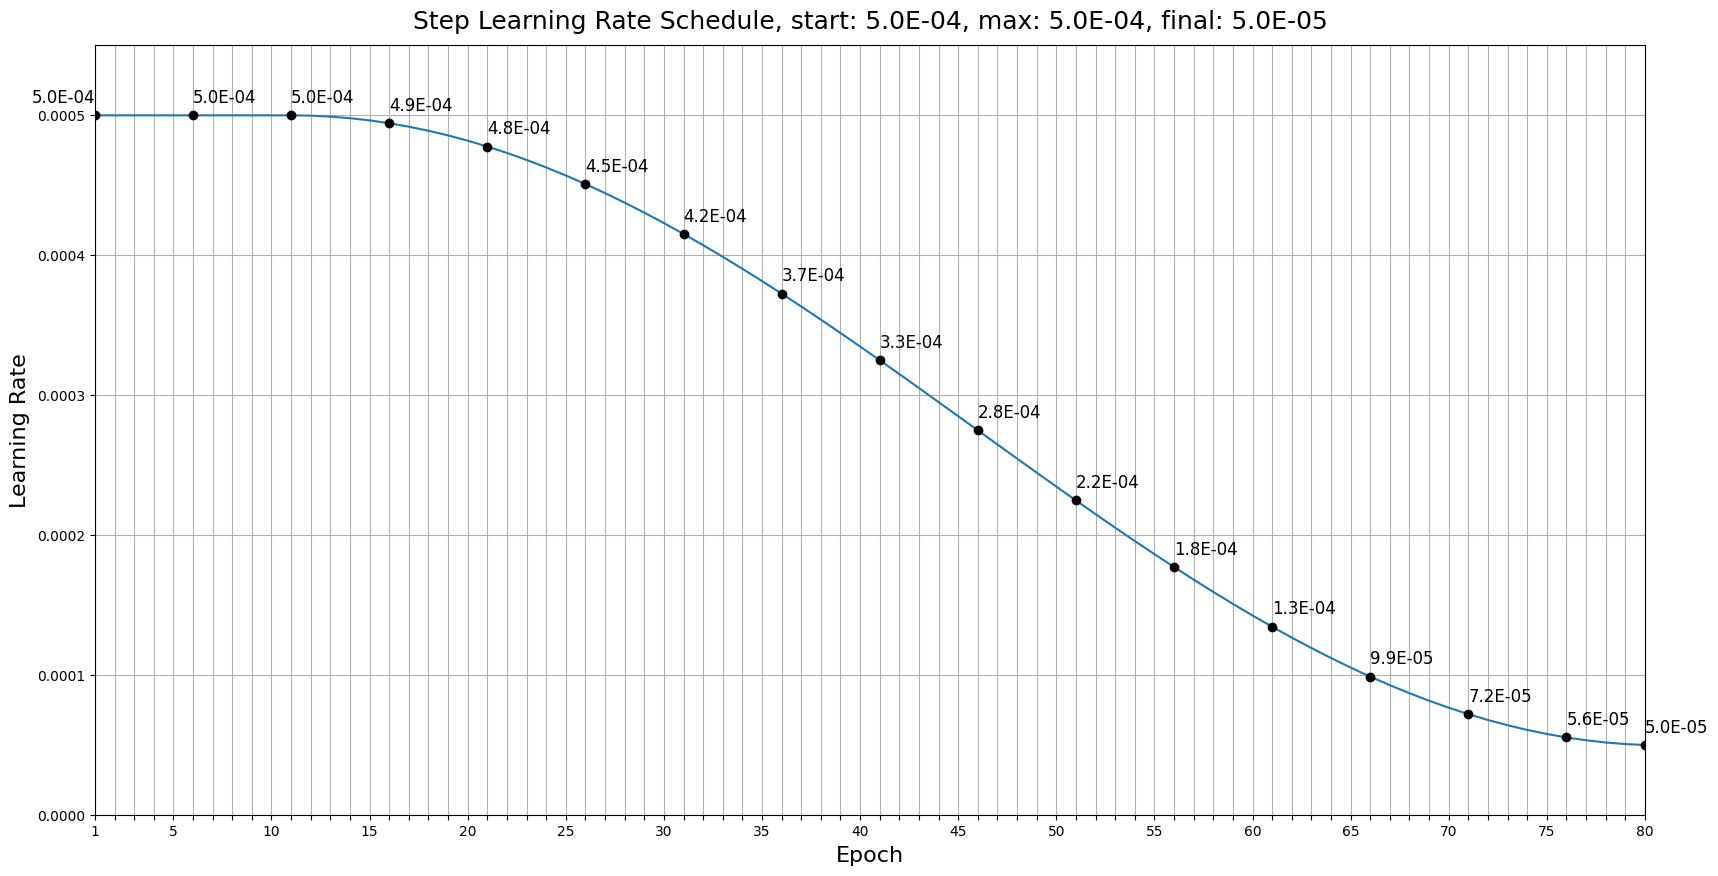

In [15]:
# Update the learning rate schedule
LR_SCHEDULE = [lrfn(epoch, LR_HIGH, LR_LOW, N_WARMUP_EPOCHS, N_EPOCHS) for epoch in range(N_EPOCHS)]

# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)

# **Saving callback**

In [16]:
save_folder = '/kaggle/working'
try:
    os.mkdir(f'{save_folder}/weights')
except:
    pass

class SaveModelPerFoldCallback(tf.keras.callbacks.Callback):
    def __init__(self, fold):
        super().__init__()
        self.fold = fold
    def on_train_end(self, logs=None):
        # Membuat folder untuk setiap fold jika belum ada
        fold_folder = f"{save_folder}/weights/fold_{self.fold}"
        os.makedirs(fold_folder, exist_ok=True)
        self.model.save_weights(f"{fold_folder}/model.h5")

class SaveModelPerEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self, fold):
        super().__init__()
        self.fold = fold
    def on_epoch_end(self, epoch: int, logs=None):
        if epoch == 3 or (epoch+1)%25 == 0:
            # Membuat folder untuk setiap epoch dalam fold jika belum ada
            epoch_folder = f"{save_folder}/weights/fold_{self.fold}/epoch_{epoch}"
            os.makedirs(epoch_folder, exist_ok=True)
            self.model.save_weights(f"{epoch_folder}/model.h5")

# **Training**

In [17]:
from sklearn.model_selection import KFold

# Initialize KFold
n_splits = 5
kf = KFold(n_splits=n_splits)

In [18]:
# Initialize an empty dictionary to store the metrics
metrics = {
    'Loss': [],
    'Accuracy': [],
    'Root Mean Square Error': [],
    'Percentage Error': [],
    'Mean Absolute Percentage Error': []
}

In [19]:
# Train and evaluate the model with KFold
start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(tffiles)):
    print('\n')
    print(f'fold: {fold}')
    
    # Define datasets
    train_files = [tffiles[i] for i in train_index]
    val_files = [tffiles[i] for i in val_index]
    
    # Get datasets
    train_dataset, num_train = get_tfrec_dataset(train_files, shuffle = -1, batch_size = batch_size,
                                                    cache = True, to_filter = 'filter_2', calculate_sample_num = True,
                                                to_repeat = True)

    val_dataset, num_val = get_tfrec_dataset(val_files, shuffle = False, batch_size = val_batch_size,
                                                    cache = True, to_filter = 'filter_1', calculate_sample_num = True)
    
    # Features
    print(train_dataset.element_spec[0])
    # Targets
    print(train_dataset.element_spec[1])
    
    print(num_train)
    print(num_val)
    
    # Get the first batch of data from the validation dataset
    batch = next(iter(val_dataset))
    
    # Print the shapes of the input data and the target data in the batch
    # 'batch[0]' corresponds to the input data and 'batch[1]' corresponds to the target data
    batch[0].shape, batch[1].shape

    validation_datasets = [val_dataset]
    validation_datasets_names = ['val']
    
    steps_per_epoch = num_train//batch_size
    val_steps_per_epoch = num_val//val_batch_size
    print(steps_per_epoch)
    print(val_steps_per_epoch)
    
    # Define the model for each fold
    model = get_model(hidden_dim = 192,max_len = X_max_len)
    
    model(batch[0])
    
    # Learning Rate Callback
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: LR_SCHEDULE[epoch], verbose=0)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=N_EPOCHS,
        steps_per_epoch = steps_per_epoch,
        validation_steps=val_steps_per_epoch,
        verbose = 2,
        callbacks=[
            lr_callback,
            SaveModelPerFoldCallback(fold),
            SaveModelPerEpochCallback(fold),
        ]
    )

    # Evaluate on validation data
    val_score = model.evaluate(val_dataset, steps=val_steps_per_epoch, verbose=1)
    print(f'validation fold {fold}: {val_score}')
    
    # Append the metrics to the dictionary
    metrics['Loss'].append(val_score[0])
    metrics['Accuracy'].append(val_score[1])
    metrics['Root Mean Square Error'].append(val_score[2])
    metrics['Percentage Error'].append(val_score[3])
    metrics['Mean Absolute Percentage Error'].append(val_score[4])    


end_time = time.time()
print('\n')
# Calculate total time in seconds
total_seconds = end_time - start_time

# Calculate time in hours
hours = total_seconds // 3600

# Calculate remaining time in minutes after extracting hours
minutes = (total_seconds % 3600) // 60

# Calculate remaining time in seconds after extracting minutes
seconds = total_seconds % 60

print(f"Time taken: {hours:.2f} hours, {minutes:.2f} minutes, and {seconds:.2f} seconds")



fold: 0
TensorSpec(shape=(128, 206), dtype=tf.float32, name=None)
TensorSpec(shape=(128, 206, 2), dtype=tf.float32, name=None)
204768
36419
1599
6
Epoch 1/80


2024-05-20 01:37:23.394115: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 01:37:24.172275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 01:38:52.153452: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 01:38:52.282738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1599/1599 - 120s - loss: 0.2447 - accuracy: 0.7603 - loss_fn_metric_rmse: 0.3331 - loss_fn_metric_pe: 34.8401 - loss_fn_metric_mape: 75.9214 - val_loss: 0.2104 - val_accuracy: 0.7832 - val_loss_fn_metric_rmse: 0.2933 - val_loss_fn_metric_pe: 32.6657 - val_loss_fn_metric_mape: 70.5734 - lr: 5.0000e-04 - 120s/epoch - 75ms/step
Epoch 2/80
1599/1599 - 62s - loss: 0.2038 - accuracy: 0.7939 - loss_fn_metric_rmse: 0.2911 - loss_fn_metric_pe: 34.6854 - loss_fn_metric_mape: 73.0624 - val_loss: 0.1930 - val_accuracy: 0.8039 - val_loss_fn_metric_rmse: 0.2776 - val_loss_fn_metric_pe: 32.5927 - val_loss_fn_metric_mape: 69.2004 - lr: 5.0000e-04 - 62s/epoch - 39ms/step
Epoch 3/80
1599/1599 - 62s - loss: 0.1943 - accuracy: 0.8047 - loss_fn_metric_rmse: 0.2826 - loss_fn_metric_pe: 33.9567 - loss_fn_metric_mape: 72.0033 - val_loss: 0.1867 - val_accuracy: 0.8116 - val_loss_fn_metric_rmse: 0.2708 - val_loss_fn_metric_pe: 32.8912 - val_loss_fn_metric_mape: 69.6267 - lr: 5.0000e-04 - 62s/epoch - 39ms/step
E

2024-05-20 03:06:57.311558: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 03:06:58.056603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 03:08:26.918694: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 03:08:27.046146: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1600/1600 - 121s - loss: 0.2431 - accuracy: 0.7615 - loss_fn_metric_rmse: 0.3306 - loss_fn_metric_pe: 34.7993 - loss_fn_metric_mape: 75.9206 - val_loss: 0.2102 - val_accuracy: 0.7816 - val_loss_fn_metric_rmse: 0.2998 - val_loss_fn_metric_pe: 40.0595 - val_loss_fn_metric_mape: 75.1716 - lr: 5.0000e-04 - 121s/epoch - 76ms/step
Epoch 2/80
1600/1600 - 64s - loss: 0.2026 - accuracy: 0.7956 - loss_fn_metric_rmse: 0.2896 - loss_fn_metric_pe: 34.5645 - loss_fn_metric_mape: 72.9261 - val_loss: 0.1924 - val_accuracy: 0.8044 - val_loss_fn_metric_rmse: 0.2786 - val_loss_fn_metric_pe: 35.0595 - val_loss_fn_metric_mape: 71.5559 - lr: 5.0000e-04 - 64s/epoch - 40ms/step
Epoch 3/80
1600/1600 - 65s - loss: 0.1938 - accuracy: 0.8056 - loss_fn_metric_rmse: 0.2817 - loss_fn_metric_pe: 33.9202 - loss_fn_metric_mape: 71.9693 - val_loss: 0.1864 - val_accuracy: 0.8112 - val_loss_fn_metric_rmse: 0.2748 - val_loss_fn_metric_pe: 34.3329 - val_loss_fn_metric_mape: 70.1066 - lr: 5.0000e-04 - 65s/epoch - 41ms/step
E

2024-05-20 04:40:51.278200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 04:40:52.041856: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 04:42:23.931348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 04:42:24.070728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1599/1599 - 125s - loss: 0.2587 - accuracy: 0.7506 - loss_fn_metric_rmse: 0.3517 - loss_fn_metric_pe: 36.2319 - loss_fn_metric_mape: 77.2168 - val_loss: 0.2129 - val_accuracy: 0.7783 - val_loss_fn_metric_rmse: 0.3001 - val_loss_fn_metric_pe: 35.5744 - val_loss_fn_metric_mape: 72.3963 - lr: 5.0000e-04 - 125s/epoch - 78ms/step
Epoch 2/80
1599/1599 - 67s - loss: 0.2093 - accuracy: 0.7861 - loss_fn_metric_rmse: 0.2964 - loss_fn_metric_pe: 35.5644 - loss_fn_metric_mape: 73.9059 - val_loss: 0.1975 - val_accuracy: 0.7988 - val_loss_fn_metric_rmse: 0.2839 - val_loss_fn_metric_pe: 34.6702 - val_loss_fn_metric_mape: 70.9223 - lr: 5.0000e-04 - 67s/epoch - 42ms/step
Epoch 3/80
1599/1599 - 65s - loss: 0.1968 - accuracy: 0.8020 - loss_fn_metric_rmse: 0.2846 - loss_fn_metric_pe: 34.2831 - loss_fn_metric_mape: 72.3314 - val_loss: 0.1887 - val_accuracy: 0.8091 - val_loss_fn_metric_rmse: 0.2738 - val_loss_fn_metric_pe: 31.7046 - val_loss_fn_metric_mape: 68.5196 - lr: 5.0000e-04 - 65s/epoch - 41ms/step
E

2024-05-20 06:15:54.245211: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 06:15:54.996107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 06:17:27.017275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 06:17:27.148497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1598/1598 - 125s - loss: 0.2517 - accuracy: 0.7552 - loss_fn_metric_rmse: 0.3425 - loss_fn_metric_pe: 35.8164 - loss_fn_metric_mape: 76.5531 - val_loss: 0.2105 - val_accuracy: 0.7810 - val_loss_fn_metric_rmse: 0.2962 - val_loss_fn_metric_pe: 36.0123 - val_loss_fn_metric_mape: 72.4815 - lr: 5.0000e-04 - 125s/epoch - 78ms/step
Epoch 2/80
1598/1598 - 65s - loss: 0.2080 - accuracy: 0.7880 - loss_fn_metric_rmse: 0.2947 - loss_fn_metric_pe: 35.2665 - loss_fn_metric_mape: 73.6458 - val_loss: 0.1974 - val_accuracy: 0.7994 - val_loss_fn_metric_rmse: 0.2846 - val_loss_fn_metric_pe: 32.7277 - val_loss_fn_metric_mape: 69.6115 - lr: 5.0000e-04 - 65s/epoch - 41ms/step
Epoch 3/80
1598/1598 - 67s - loss: 0.1969 - accuracy: 0.8023 - loss_fn_metric_rmse: 0.2840 - loss_fn_metric_pe: 34.0910 - loss_fn_metric_mape: 72.2389 - val_loss: 0.1896 - val_accuracy: 0.8085 - val_loss_fn_metric_rmse: 0.2762 - val_loss_fn_metric_pe: 33.6994 - val_loss_fn_metric_mape: 69.8398 - lr: 5.0000e-04 - 67s/epoch - 42ms/step
E

2024-05-20 07:50:51.066039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 07:50:51.847451: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 07:52:22.016376: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-20 07:52:22.156950: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1612/1612 - 124s - loss: 0.2508 - accuracy: 0.7582 - loss_fn_metric_rmse: 0.3404 - loss_fn_metric_pe: 34.9210 - loss_fn_metric_mape: 76.2156 - val_loss: 0.2097 - val_accuracy: 0.7814 - val_loss_fn_metric_rmse: 0.2953 - val_loss_fn_metric_pe: 35.0234 - val_loss_fn_metric_mape: 72.0163 - lr: 5.0000e-04 - 124s/epoch - 77ms/step
Epoch 2/80
1612/1612 - 68s - loss: 0.2069 - accuracy: 0.7894 - loss_fn_metric_rmse: 0.2940 - loss_fn_metric_pe: 34.9393 - loss_fn_metric_mape: 73.4505 - val_loss: 0.1956 - val_accuracy: 0.8002 - val_loss_fn_metric_rmse: 0.2799 - val_loss_fn_metric_pe: 33.8570 - val_loss_fn_metric_mape: 70.3230 - lr: 5.0000e-04 - 68s/epoch - 42ms/step
Epoch 3/80
1612/1612 - 68s - loss: 0.1963 - accuracy: 0.8024 - loss_fn_metric_rmse: 0.2842 - loss_fn_metric_pe: 34.1163 - loss_fn_metric_mape: 72.2346 - val_loss: 0.1893 - val_accuracy: 0.8084 - val_loss_fn_metric_rmse: 0.2741 - val_loss_fn_metric_pe: 31.3745 - val_loss_fn_metric_mape: 68.1372 - lr: 5.0000e-04 - 68s/epoch - 42ms/step
E

# **Plotting loss**

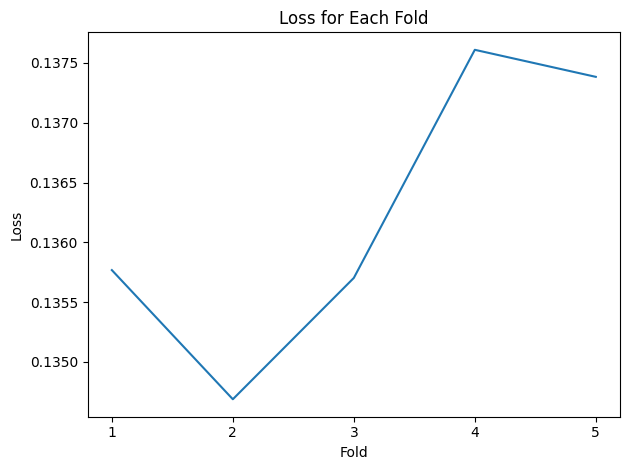

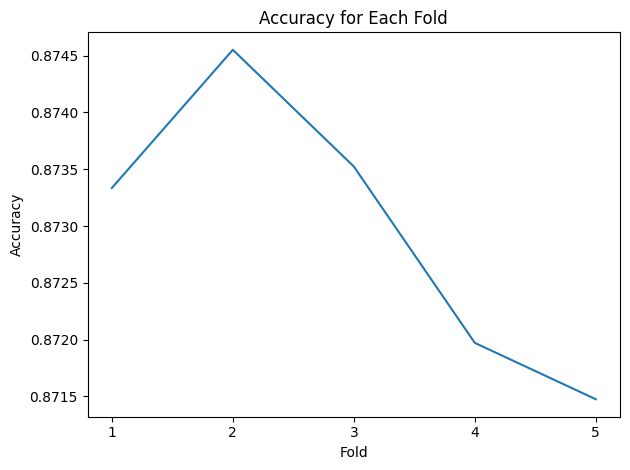

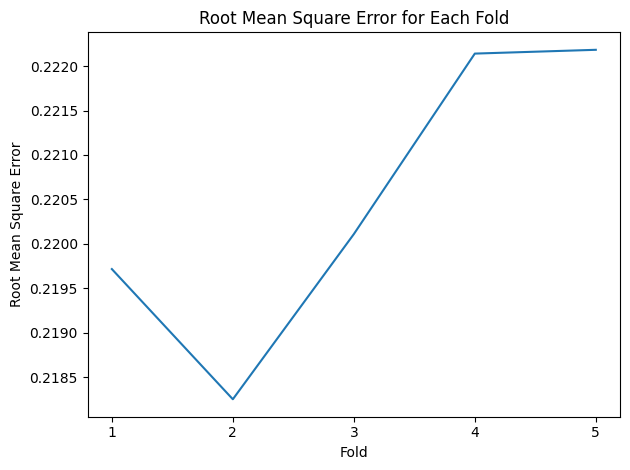

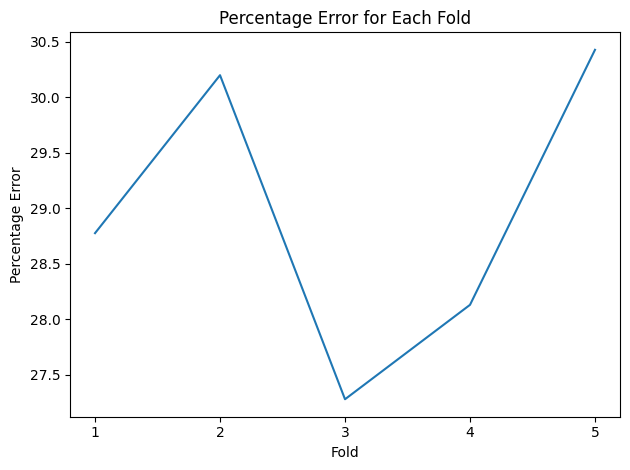

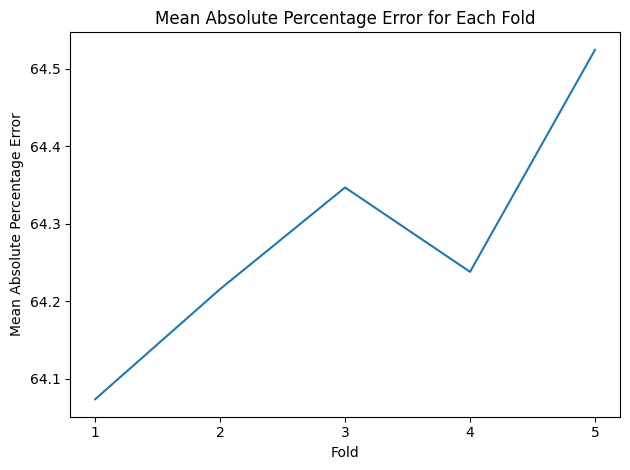

In [20]:
from matplotlib.ticker import MaxNLocator

# Plot the metrics
for i, (metric, values) in enumerate(metrics.items()):
    # Create an array of integers for the x-axis that starts from 1
    x = np.arange(1, len(values) + 1)

    # Create a new figure for each plot
    plt.figure()

    plt.plot(x, values)
    plt.title(f'{metric} for Each Fold')
    plt.xlabel('Fold')
    plt.ylabel(metric)

    # Set the x-axis to display integer values
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Adjust the size of the plot
    plt.tight_layout()

    plt.show()